# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1 Introduction

---

My main goal is to predict whether an offer sent will be completed. To do so. I first explore the data that I have and then bulid two models, random forest and logist regression, to predict the success of an offer.

This workflow is organzied in the following sections:

- 2 Assessing and Cleaning Data
- 3 EDA
- 4 Data Modelling

In [1]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt
import math
import json
% matplotlib inline

import time

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import classification_report


from sklearn.linear_model import LogisticRegression

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
pd.set_option('max_columns', None)

# 2 Assessing and Cleaning Data

---


## 2.1 portfolio

---

We have different datapoints about offers such as offer types in this datasource. As a begining, I check how many record are in this datasource and visualy check a sample:

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.sort_values(by='offer_type').head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


There are 10 records in this table with three types of offer (i.e. bogo, discount, and informational). However, the values `channels` column is a list. I would like to create a column for each element and use 0 and 1 to determine what channel(s) is used to send out an offer.

**`Cleaning:`**
   - creating 4 columns with 0 and 1 values for `channels` (web, email, mobile, social)

In [6]:
channels_df = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)

channels_df.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [7]:
portfolio_clean = (pd.concat([portfolio, channels_df], axis=1, join='inner')
                   .drop('channels', axis=1)
                  )
portfolio_clean.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


## 2.2 profile

---

This stores the customers' data. So let's take a look at a sample and check whether there is any missing values:

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.sample(5)

,age,became_member_on,gender,id,income
15125,118,20160905,None,b95e05600e9e4162b69d28cc9dac70e0,NaN
389,36,20180315,M,f5b84c63d6514f02bed8258e627f172d,31000.0
10509,77,20171008,M,5f99f2a855484c3884f043c592d96447,53000.0
2722,50,20170215,M,83de7542018d455d9afa423626d7f5d3,64000.0
3026,28,20180714,M,e7511e8ef7ae416080fa63b5f80e1fe2,52000.0


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
# get descriptive statistics about numerical data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
# what are the gender distribution?
df_gender = profile.groupby('gender').count()['id'] * 100 / profile.shape[0]
df_gender

gender
F    36.052941
M    49.905882
O     1.247059
Name: id, dtype: float64

In [13]:
# is there any duplicated id? (I want to have one row for each customer)
profile.id.duplicated().sum()

0

In [14]:
# number of nulls for gender
profile.gender.isnull().sum()

2175

In [15]:
# number of nulls for income
profile.income.isnull().sum()

2175

There are **17,000** records of customers in this dataframe and looking at above result, I can conclude two main issues:

1. there are **2,175** nulls for gender and income. 
2. the max age is 118 while the 75 percentile is 73. It seem that there are some outliers in my data.

The next question for me to address is whether all of the one without age are the one without income. so, I am checking this in the next cell:

In [16]:
profile[(profile.gender.isnull()) & (profile.income.isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [17]:
profile[(profile.gender.isnull()) & (profile.income.isnull())].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


Above results indicate that not only those without age are the same as ones without income, but also the age of all of them are 118 years old, which I suspected to be outlier. Thereore, I have to delete these nulls from my dataframe. However, I am going to do this after I join this with transaction dataframe because, So, I will be able to deleted all the records in transaction dataframe for these customers. So, This will be in the list of things to do later.

**`Cleaning`**

In addition to missing values nd outliers, I would like to perform two more changes in my data structure:

1. creating year, month and day column from became_member_on and create dummies for year
2. create dummies for gender --> `I will do this after I join the dataframes and deleted the null values`

In [18]:
# create a copy of the main dataframe
profile_clean = profile.copy()

# convert became_member_on into date type
profile_clean['became_member_on'] = profile_clean['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [19]:
# create year and month column
profile_clean['membership_year'] = pd.DatetimeIndex(profile_clean['became_member_on']).year
profile_clean['membership_month'] = pd.DatetimeIndex(profile_clean['became_member_on']).month
profile_clean['membership_day'] = pd.DatetimeIndex(profile_clean['became_member_on']).day

In [20]:
profile_clean.sample(5)

,age,became_member_on,gender,id,income,membership_year,membership_month,membership_day
15952,73,2017-08-23,M,50d964e03e2d4b52ba7d8265e3d9f18a,57000.0,2017,8,23
8039,92,2015-08-31,O,443f2cf24300401e8111eb338c790549,97000.0,2015,8,31
5559,81,2018-04-23,M,3149365bc86c4f71ad6c665df05e6f6f,79000.0,2018,4,23
11858,33,2016-05-17,M,165faf21d18549ed802e14b605f6db08,64000.0,2016,5,17
530,94,2014-11-28,M,00bbce6533f44ddeaf4dd32bcab55441,50000.0,2014,11,28


In [21]:
# create dummies for membership_year
df_year = pd.get_dummies(profile_clean['membership_year'])

df_year.head()

,2013,2014,2015,2016,2017,2018
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [22]:
drop_col = ['membership_year', 'membership_month', 'membership_day']
profile_clean = (pd.concat([profile_clean, df_year], axis=1, join='inner')
                   .drop(drop_col, axis=1)
                  )

In [23]:
profile_clean.sample(5)

,age,became_member_on,gender,id,income,2013,2014,2015,2016,2017,2018
16554,69,2016-06-30,M,1cb3a1e696f3495795deb0a17c07d869,92000.0,0,0,0,1,0,0
3436,44,2015-07-29,F,d7dd26d7142d4e51b63770cf9db2f91f,84000.0,0,0,1,0,0,0
13800,80,2017-11-07,F,89c233f3e4f04464ac5cc15e55caa1a1,52000.0,0,0,0,0,1,0
5431,65,2017-10-21,M,47b014746315472f8127c2031441506e,36000.0,0,0,0,0,1,0
6423,57,2018-01-06,M,db0bffb1c28d416a84f7a224a86bd6de,48000.0,0,0,0,0,0,1


## 2.3 transcript

---

The sam eas before, let's investigate the data by looking at general characteristics:

In [23]:
transcript.shape

(306534, 4)

In [24]:
transcript.sample(5)

,event,person,time,value
299321,transaction,e54b14de96bb4166bf1db3919de76f1b,684,{'amount': 18.27}
93292,transaction,b6d81016825f4ee99f3a5f173b2bdb93,240,{'amount': 30.13}
161811,offer received,2e8c6f012b6a49208dd76bf9428c4342,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
66849,transaction,87d77223236342d5983c7d7c5e598ef6,168,{'amount': 15.48}
286766,offer completed,c2bc9cc1972345da8d1ac71c83ae4b23,636,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...


In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [26]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are **306,534** is without any missing values. It a log table table in which all the events per customer is recorded. let's take one customer and look at its history:

In [27]:
transcript[transcript['person'] == 'b3a1272bc9904337b331bf348c3e8c17'].sort_values(by='time')


,event,person,time,value
12619,offer received,b3a1272bc9904337b331bf348c3e8c17,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
31105,transaction,b3a1272bc9904337b331bf348c3e8c17,48,{'amount': 4.02}
36911,transaction,b3a1272bc9904337b331bf348c3e8c17,72,{'amount': 2.22}
49498,transaction,b3a1272bc9904337b331bf348c3e8c17,138,{'amount': 3.94}
101457,transaction,b3a1272bc9904337b331bf348c3e8c17,276,{'amount': 2.14}
148924,transaction,b3a1272bc9904337b331bf348c3e8c17,396,{'amount': 6.71}
163340,offer received,b3a1272bc9904337b331bf348c3e8c17,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
171199,offer viewed,b3a1272bc9904337b331bf348c3e8c17,414,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
171200,transaction,b3a1272bc9904337b331bf348c3e8c17,414,{'amount': 0.77}
177255,transaction,b3a1272bc9904337b331bf348c3e8c17,426,{'amount': 7.12}


Above sample shows that transcript is a log table in which every action of the person is logged in. 

**`Cleaning:`**

One issue is that the values in `value` column is dictionaries with two possible keys: offer id and amount. So, my goal is to extract `offer id` and `amount` from `value` 




In [28]:
### Learning for me:

# keys = transcript['keys'].tolist()
# keys[:10]


# another way
# transcript['offer_id'] = transcript.apply(lambda x: x['value'].get('offer id'), axis=1)

In [29]:
# create a copy of transcript
transcript_clean = transcript.copy()

# let's see what are the keys in the value
transcript_clean['value'].apply(lambda x: x.keys()).value_counts()


(amount)              138952
(offer id)            134001
(offer_id, reward)     33578
(offer id)                 1
(offer_id, reward)         1
(amount)                   1
Name: value, dtype: int64

the only other featur is reward which we can get it from other data sources.

In [30]:
transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x.get('offer id'))
transcript_clean['amount_spent'] = transcript_clean['value'].apply(lambda x: x.get('amount'))
transcript_clean = transcript_clean.drop('value', axis=1)

In [31]:
transcript_clean.sample(10)

,event,person,time,offer_id,amount_spent
31474,transaction,2825186736d4433c98653bcea5957cb3,54,None,7.88
189583,transaction,2975799195d449efaa81e495cdabd1ed,462,None,17.87
301808,transaction,d251f248075040f2a4f8c1b05a0688de,690,None,14.63
10091,offer received,7d1dd620977d4d61a5a8c172b3b68147,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN
272340,transaction,d7fec020017649a7a13a924c04e8c07b,600,None,6.55
248069,offer received,1e8fa28875f84db89e0b7a9a7d99f639,576,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
28343,offer completed,891ce7b6861f49f09260c9b7bfcf14c8,42,None,NaN
193263,transaction,c35b03c286fa44bea8a1739558a87d3f,474,None,15.00
75559,transaction,2423ad34c87244f9a6dba4f1d139531f,186,None,10.06
220681,offer viewed,2ec52ca9f97f4feb9b5790ee4e0bce8c,510,fafdcd668e3743c1bb461111dcafc2a4,NaN


In [32]:
# Let's pick up the same person
transcript_clean[transcript_clean['person'] == 'b3a1272bc9904337b331bf348c3e8c17'].sort_values(by='time')

,event,person,time,offer_id,amount_spent
12619,offer received,b3a1272bc9904337b331bf348c3e8c17,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
31105,transaction,b3a1272bc9904337b331bf348c3e8c17,48,None,4.02
36911,transaction,b3a1272bc9904337b331bf348c3e8c17,72,None,2.22
49498,transaction,b3a1272bc9904337b331bf348c3e8c17,138,None,3.94
101457,transaction,b3a1272bc9904337b331bf348c3e8c17,276,None,2.14
148924,transaction,b3a1272bc9904337b331bf348c3e8c17,396,None,6.71
163340,offer received,b3a1272bc9904337b331bf348c3e8c17,408,ae264e3637204a6fb9bb56bc8210ddfd,NaN
171199,offer viewed,b3a1272bc9904337b331bf348c3e8c17,414,ae264e3637204a6fb9bb56bc8210ddfd,NaN
171200,transaction,b3a1272bc9904337b331bf348c3e8c17,414,None,0.77
177255,transaction,b3a1272bc9904337b331bf348c3e8c17,426,None,7.12


The above result shows that:

1. the `transaction` event is recorded independently from offer
2. we have `offer_id` for both `offer received` and `offer viewed`, but, there is no `offer_id` for `offer completed`. this means we cannot directly conclude from the data whcih offer has been completed and we need to come up with some assumptions to decisde whcih offers have been successfully completed (I will explain this in details later)

## 2.4 Final dataframe: creating `is_successful` feature

---

As mentioned in the previous section, one cannot conclude which offer has been completed by merely looking at `offer_complete` records because they do not have any `offer_id`. So, I need to make some assumptions in order to consider an offer being successfully completed. 

To this end, I need to first join the dataframe to have all data points at one place and then set the assumptions.
Based on my assumption, every `offer_recived` is considered as successfully completed if:

1. it has been viewed, and
2. is completed within the duration that offer is valid

The following cells are dedicated to this process.

In [33]:
df_transcript_portfolio = (pd.merge(transcript_clean, portfolio_clean, left_on='offer_id', right_on='id', how='left')
                           .drop('id', axis=1)
                          )

In [34]:
df_transcript_portfolio.sample(5)

,event,person,time,offer_id,amount_spent,difficulty,duration,offer_type,reward,email,mobile,social,web
204017,offer received,e15aaea078cf43a89501e25503ca8558,504,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
161085,offer received,731bc41295b343c5b3828ff0bfe7a494,408,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
34763,transaction,f0ef63b28f2540fe811b8d9935ec61f5,66,None,4.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126503,transaction,afcc1f046f1740349cd370d89a933cd7,336,None,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267663,offer completed,467f5f3edc6c407ebb189d57e839bfd3,588,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> the `offer complete` does not have any offer_id which makes it complecated to find out which offer has been successfull

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
df_transcript_portfolio['is_successful'] = 0

for customer in tqdm(df_transcript_portfolio.person.unique()):
    df_customer = df_transcript_portfolio[df_transcript_portfolio['person'] == customer].sort_values(by=['time'])
    for index, row in df_customer.iterrows():
        if row['event'] == 'offer received':
            offer_end_time = row['time'] + (row['duration'] * 24)
            df_duration = df_customer[(df_customer['time'] >= row['time']) & (df_customer['time'] <= offer_end_time)]
            viewed_time = df_duration[(df_duration['event'] == 'offer viewed') & (df_duration['offer_id'] == row['offer_id'])].time.values.tolist()
            if len(viewed_time) > 0:
                first_viewed_time = viewed_time[0]
                list_of_events = df_duration[(df_duration['time'] >= first_viewed_time) & (df_duration['event'] == 'offer completed')].event.values.tolist()
                df_transcript_portfolio["is_successful"].iloc[index] = 1 if len(list_of_events) > 0 else 0

In [44]:
df_join = (pd.merge(df_transcript_portfolio, profile_clean, left_on='person', right_on='id', how='left')
           .drop(['id'], axis=1)
          )

In [45]:
df_join.sample(5)

,event,person,time,offer_id,amount_spent,difficulty,duration,offer_type,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018
220048,offer completed,ae56c4d76ac84a639a31693086044dd9,510,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,52,2017-06-06,M,69000.0,0,0,0,0,1,0
133374,transaction,2825186736d4433c98653bcea5957cb3,354,None,3.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18,2013-08-08,M,56000.0,1,0,0,0,0,0
73783,transaction,8dadd4f054dd4b57a445e8439956ee67,180,None,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,59,2018-03-02,M,75000.0,0,0,0,0,0,1
79810,offer viewed,5682c5153c7d4ef7b3eb08208c546dde,198,3f207df678b143eea3cee63160fa8bed,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0,64,2017-11-26,F,50000.0,0,0,0,0,1,0
104937,transaction,8e508511652c446a9debf0c20f5f5163,300,None,21.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,64,2016-02-07,M,108000.0,0,0,0,1,0,0


Now that I have everything in one dataframe, I can aply the last two cleaning that I needed to do whihc are:

1. delete the records without age and income (whcih were outliers as well)
2. create dummies for `gender`

In [47]:
# delete the nulls
cleaned_df = df_join[df_join['income'].notnull()]
cleaned_df[['income', 'age']].describe()

,income,age
count,272762.000000,272762.000000
mean,64337.000755,53.840696
std,21243.762941,17.551337
min,30000.000000,18.000000
25%,48000.000000,41.000000
50%,62000.000000,55.000000
75%,78000.000000,66.000000
max,120000.000000,101.000000


In [50]:
cleaned_df['age'].isnull().sum()

0

In [51]:
cleaned_df['gender'].isnull().sum()

0

In [52]:
# convert gender into dummies
gender_df = pd.get_dummies(cleaned_df['gender'].apply(pd.Series).stack()).sum(level=0)
cleaned_df = (pd.concat([cleaned_df, gender_df], axis=1, join='inner')
#               .drop('gender', axis=1) # I will delete this later after EDA
             )

In [53]:
cleaned_df.sample(5)

,event,person,time,offer_id,amount_spent,difficulty,duration,offer_type,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O
140137,offer completed,fd75302f189044e083f32152398889c5,372,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67,2017-09-15,M,65000.0,0,0,0,0,1,0,0,1,0
17354,transaction,0a34323c7f254960979fb7c6cafa6b3c,6,None,14.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,68,2015-02-10,M,70000.0,0,0,1,0,0,0,0,1,0
300151,transaction,e6eba409f81e4f73948e9508923de90c,684,None,15.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,43,2016-12-15,M,56000.0,0,0,0,1,0,0,0,1,0
26350,offer viewed,193ffaca5cd745f284f6c51df0f9412e,36,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,0,77,2017-08-08,M,77000.0,0,0,0,0,1,0,0,1,0
172515,offer viewed,751c9dd9226043c9a0d9206d53729936,420,3f207df678b143eea3cee63160fa8bed,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0,45,2017-08-06,F,52000.0,0,0,0,0,1,0,1,0,0


In [54]:
cleaned_df.to_csv("cleaned_data.csv", index=False)

# 2 EDA

---

## 2.1 Feature Engineering 

Now that I have all the information that I need, I am going to create the final dataframe to be used in exploration as well as modelling. My main goal is to predict whether a recived offer will be completed or not. therefore, I need to have only offers received with is_succesful column, i.e. I do not need the viewed and completed events because they have been used in the is_successful logic. In addition. I will exclude the informational offers because they do not have any completed event (so success cannot be define for them). I also need some demgraphic characteristics of the person who received the offer in my modelling stage. Therefore, I am going to tranform further my dataframe by applying the following changes:

1. calculate the total amount each customer spent
2. create a dummy that shows which offer has been received
3. add columns that shows how many different types of offer each customer has received in total

After that, I have the final dataframe for data exploration.

In [24]:
df_final = pd.read_csv("cleaned_data.csv")

In [25]:
df_final.sample(5)

,event,person,time,offer_id,amount_spent,difficulty,duration,offer_type,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O
130597,offer completed,45732be078d146118d0e123eede47771,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76,2016-05-08,M,88000.0,0,0,0,1,0,0,0,1,0
185179,offer received,37aafe9fc59444e3b10a36ad9e6eb406,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,0,82,2018-03-26,M,81000.0,0,0,0,0,0,1,0,1,0
194228,offer viewed,8ebaac00906443a790b0afd653489897,510,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0,38,2015-12-13,M,56000.0,0,0,1,0,0,0,0,1,0
204663,offer completed,3c9afb70b2cb42a1ac2e5ff8cdc5be29,528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63,2016-08-24,M,99000.0,0,0,0,1,0,0,0,1,0
141945,offer received,402d0d57aacc4533ab4384581d0fae61,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0,55,2017-09-24,M,113000.0,0,0,0,0,1,0,0,1,0


### Compute total amount spent per cusomer

In [26]:
d = {'amount_spent': 'total_spent'}
df_amount = df_final.rename(columns=d).groupby('person', sort=False, as_index=False)['total_spent'].sum()

# send way:
# df_amount = df.groupby('person', sort=False)["amount"].sum().reset_index(name ='total_spent')

In [27]:
df_amount.sample(5)

,person,total_spent
8658,7b979f53512747b4a195dd7bf0867010,10.37
12365,51b78fab74014eec803261b88fe2955f,148.28
10616,ddc4e3d37b3b451495236f41de79dfa1,54.67
10497,ac3e5e1cf92a4cbe84636087fa45204a,124.71
1932,ac3b8c9879304a9db841fa510d931ea7,245.10


### Compute the total number of different offers received per customer

In [28]:
df_subset = df_final.loc[df_final['event'] == "offer received", ['person', 'offer_type']]
offer_type = pd.get_dummies(df_subset['offer_type'].apply(pd.Series).stack()).sum(level=0)

In [29]:
df_type_dummy = (pd.concat([df_subset, offer_type], axis=1, join='inner')
                   .drop('offer_type', axis=1)
                  )

In [30]:
df_type_dummy.sample(5)

,person,bogo,discount,informational
138823,a6292629dfb24fc583dd6d324d47a5dd,1,0,0
48947,f6ec566d8f1f45aa8a3e062576e705d1,1,0,0
137159,5cbf9a8a153249c19534afd142693483,0,1,0
50782,38bf225453dd48369e079aada6f5d392,0,0,1
109745,b65affd9e07346a1906364a396950e3d,1,0,0


In [31]:
new_col_names = ['person' ,'total_received_bogo', 'total_received_discount', 'total_received_informational']
d = {'bogo': 'sum', 'discount': 'sum', 'informational': 'sum'}
df_person_type = df_type_dummy.groupby(['person']).agg(d).reset_index()
df_person_type.columns = new_col_names
df_person_type.sample(5)

,person,total_received_bogo,total_received_discount,total_received_informational
10093,acc86d3bd45d4e4688cd1be20e5a7294,1,1,3
10744,b84ee50d915e40709e498538524be30d,2,3,0
6951,785231f27bc642aaba43022e1dcdd72b,2,0,2
11035,bd3714abf1654f58939f379f88378882,2,0,2
6424,6f04a68e93df44d1b2329a399016452b,1,2,2


### Filter the datafrae for only non informational recived offers

In [32]:
df_offer_received = df_final[(df_final['event'] == "offer received") & (df_final['offer_type'] != "informational")]

### Joining the dataframes (i.e. df_amount, df_person_type and df_offer_received)

In [33]:
df_join = pd.merge(df_offer_received, df_person_type, left_on='person', right_on='person', how='left')
df_join = pd.merge(df_join, df_amount, left_on='person', right_on='person', how='left')
df_join.sample(5)

,event,person,time,offer_id,amount_spent,difficulty,duration,offer_type,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent
40117,offer received,0555eeabf1284cfd85c306caf9360d05,504,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0,84,2016-08-28,F,73000.0,0,0,0,1,0,0,1,0,0,1,2,2,102.04
22055,offer received,10c9361517054a538aade27e19884bbc,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0,51,2017-12-10,M,45000.0,0,0,0,0,1,0,0,1,0,2,3,0,24.57
53157,offer received,d02c8f94e7b7461da70b6e622ad87488,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,1,63,2017-01-26,F,53000.0,0,0,0,0,1,0,1,0,0,2,1,3,298.56
52201,offer received,cfe1dbd54f1549da8ce88b453d8d5b8b,576,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0,73,2017-11-22,M,54000.0,0,0,0,0,1,0,0,1,0,3,1,1,90.35
9830,offer received,6bdd08b358ac44cbb9b379ff6ad6e9cc,168,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,0,58,2015-12-30,M,81000.0,0,0,1,0,0,0,0,1,0,4,1,0,125.35


### Create dummies for the offer received type

In [34]:
drop_columns = ['amount_spent', 'offer_type']
offer_received_type_df = pd.get_dummies(df_join['offer_type'].apply(pd.Series).stack()).sum(level=0)
df_join = (pd.concat([df_join, offer_received_type_df], axis=1, join='inner')
           .drop(drop_columns, axis=1)
          )


In [35]:
df_join.sample(5)

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount
14978,offer received,165faf21d18549ed802e14b605f6db08,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0,33,2016-05-17,M,64000.0,0,0,0,1,0,0,0,1,0,1,0,0,53.44,1,0
8184,offer received,e268ed3a6b494da8a4f91c92d031eed3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,84,2015-12-07,F,87000.0,0,0,1,0,0,0,1,0,0,3,2,1,91.14,1,0
41127,offer received,123b82af56404ec3bece3de96b947fc2,504,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0,54,2017-09-11,F,119000.0,0,0,0,0,1,0,1,0,0,1,2,1,125.69,0,1
31600,offer received,c5728a98d82447c4a6d6da5a5f2f3060,408,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0,47,2017-12-21,F,65000.0,0,0,0,0,1,0,1,0,0,0,3,2,39.62,0,1
45407,offer received,dcda2764a0754332a449b354e0d3acf8,576,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0,88,2018-05-24,F,51000.0,0,0,0,0,0,1,1,0,0,0,4,2,153.41,0,1


In [36]:
df_join.sample(5)

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount
13420,offer received,d6990e9615924acf80dbdf991238c371,168,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1,70,2017-10-25,M,31000.0,0,0,0,0,1,0,0,1,0,3,2,0,77.55,1,0
30840,offer received,58a4e015bea149deaf751f1bb59a9606,408,ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,10.0,1.0,1.0,1.0,0.0,1,41,2018-01-15,M,35000.0,0,0,0,0,0,1,0,1,0,2,3,1,107.61,1,0
42680,offer received,8c3be843043c4ed9893ad9aef2a3c71a,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,2.0,1.0,1.0,1.0,1.0,1,57,2017-11-14,M,59000.0,0,0,0,0,1,0,0,1,0,0,3,1,269.24,0,1
24472,offer received,612fd8cc4c5c4ad8ad2912462b227089,336,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1,48,2017-03-26,F,82000.0,0,0,0,0,1,0,1,0,0,2,2,1,170.39,1,0
32770,offer received,10d6b9fa4ba04fcf81fae5bbf6ccedcb,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,1.0,1.0,0.0,1.0,0,44,2016-05-01,M,73000.0,0,0,0,1,0,0,0,1,0,2,2,0,195.07,1,0


Although the `difficulty` and `duration` seem to be numerical values, they only gets the fixed values and we cannot take mean or variance (in general, any kind of descriptives). Therefore, I treat them as categorical variables and create dummies for them.

**`Cleaning`**

- create dummies for `difficulty` and `duration`: 

In [37]:
# convert difficulty into dummies

difficulty_df = pd.get_dummies(df_join['difficulty'].apply(pd.Series).stack()).sum(level=0)        
difficulty_df.columns = ['difficulty_5', 'difficulty_7', 'difficulty_10', 'difficulty_20']

df_join_2 = (pd.concat([df_join, difficulty_df], axis=1, join='inner')
#               .drop('difficulty', axis=1) # I will delete this later after EDA
             )


In [38]:
df_join_2.sample(5)

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount,difficulty_5,difficulty_7,difficulty_10,difficulty_20
19568,offer received,9f6907ec4e1846dc9266b0289bbce9fb,336,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,3.0,1.0,1.0,1.0,1.0,1,32,2017-11-24,M,68000.0,0,0,0,0,1,0,0,1,0,3,3,0,13.54,0,1,0,1,0,0
24969,offer received,3494b039530c491a9dba3d132aa4bbec,336,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,1,79,2016-04-10,F,78000.0,0,0,0,1,0,0,1,0,0,1,1,3,236.40,0,1,0,0,1,0
38388,offer received,aaefb780b5a4410cb9f467f2bad725f3,504,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,1,48,2017-11-10,M,71000.0,0,0,0,0,1,0,0,1,0,1,3,2,276.21,0,1,0,0,1,0
26015,offer received,a6fce370a2ce4df995fc4899bfeb3b6a,336,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,2.0,1.0,1.0,1.0,1.0,1,66,2017-12-21,O,40000.0,0,0,0,0,1,0,0,0,1,3,2,1,241.12,0,1,0,0,1,0
9502,offer received,d87f7a8a8c874c8ab626b8a4f4bf7aef,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,1,50,2016-04-23,M,86000.0,0,0,0,1,0,0,0,1,0,2,1,0,301.39,0,1,0,0,0,1


In [39]:
df_join_2.duration.value_counts()

7.0     26654
10.0    13378
5.0     13169
Name: duration, dtype: int64

In [40]:
# convert duration into dummies

duration_df = pd.get_dummies(df_join_2['duration'].apply(pd.Series).stack()).sum(level=0)        
duration_df.columns = ['duration_5', 'duration_7', 'duration_10']

df_join_3 = (pd.concat([df_join_2, duration_df], axis=1, join='inner')
#               .drop('duration', axis=1) # I will delete this later after EDA
             )

In [41]:
df_join_3.head()

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount,difficulty_5,difficulty_7,difficulty_10,difficulty_20,duration_5,duration_7,duration_10
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,75,2017-05-09,F,100000.0,0,0,0,0,1,0,1,0,0,3,0,1,159.27,1,0,1,0,0,0,0,1,0
1,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0,68,2018-04-26,M,70000.0,0,0,0,0,0,1,0,1,0,1,2,1,57.73,0,1,0,0,1,0,0,1,0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1,65,2018-02-09,M,53000.0,0,0,0,0,0,1,0,1,0,4,2,0,36.43,1,0,1,0,0,0,1,0,0
3,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,1,61,2017-09-11,F,57000.0,0,0,0,0,1,0,1,0,0,3,1,1,85.55,0,1,0,0,0,1,0,0,1
4,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,0,62,2016-02-11,F,71000.0,0,0,0,1,0,0,1,0,0,0,6,0,160.25,0,1,0,0,0,1,0,0,1


In [42]:
df_join_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 0 to 53200
Data columns (total 38 columns):
event                           53201 non-null object
person                          53201 non-null object
time                            53201 non-null int64
offer_id                        53201 non-null object
difficulty                      53201 non-null float64
duration                        53201 non-null float64
reward                          53201 non-null float64
email                           53201 non-null float64
mobile                          53201 non-null float64
social                          53201 non-null float64
web                             53201 non-null float64
is_successful                   53201 non-null int64
age                             53201 non-null int64
became_member_on                53201 non-null object
gender                          53201 non-null object
income                          53201 non-null float64
2013                  

## 2.2 Using visualization for EDA

In [5]:
cleaned_df = df_join_3.copy()

In [11]:
cleaned_df.head()

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount,difficulty_5,difficulty_7,difficulty_10,difficulty_20,duration_5,duration_7,duration_10
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,75,2017-05-09,F,100000.0,0,0,0,0,1,0,1,0,0,3,0,1,159.27,1,0,1,0,0,0,0,1,0
1,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0,68,2018-04-26,M,70000.0,0,0,0,0,0,1,0,1,0,1,2,1,57.73,0,1,0,0,1,0,0,1,0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1,65,2018-02-09,M,53000.0,0,0,0,0,0,1,0,1,0,4,2,0,36.43,1,0,1,0,0,0,1,0,0
3,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,1,61,2017-09-11,F,57000.0,0,0,0,0,1,0,1,0,0,3,1,1,85.55,0,1,0,0,0,1,0,0,1
4,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,0,62,2016-02-11,F,71000.0,0,0,0,1,0,0,1,0,0,0,6,0,160.25,0,1,0,0,0,1,0,0,1


Precentage of completed offers 54.59107911505423
Precentage of not completed offers 45.40892088494577


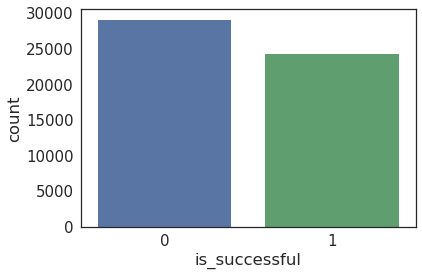

In [40]:
# do we have a calass inbalanced  problem? I checked this by looking into the distribution of target variable
ax = sns.countplot(cleaned_df.is_successful, label='count')
completed, not_completed = cleaned_df.is_successful.value_counts() / cleaned_df.shape[0] * 100


print("Precentage of completed offers", completed)
print("Precentage of not completed offers", not_completed)

So, it seems that I not have class imbalanced problem with traget variable.

The next question that I need to answer is if I need to normalized the numerical features.

In [14]:
cleaned_df[['age', 'income', 'total_received_bogo', 'total_received_discount', 'total_received_informational', 'total_spent']].describe()



,age,income,total_received_bogo,total_received_discount,total_received_informational,total_spent
count,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000
mean,54.321610,65371.590760,1.986184,2.003308,0.750775,121.209380
std,17.384883,21639.081109,1.136913,1.149349,0.803546,134.283972
min,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,1.000000,1.000000,0.000000,32.380000
50%,55.000000,64000.000000,2.000000,2.000000,1.000000,89.370000
75%,66.000000,80000.000000,3.000000,3.000000,1.000000,167.460000
max,101.000000,120000.000000,6.000000,6.000000,5.000000,1608.690000


The variation between variables are huge and they need to be normalized:

In [8]:
num_features = ['age', 'income', 'total_received_bogo', 'total_received_discount', 'total_received_informational', 'total_spent']
df_normalized = cleaned_df.copy()
for column in df_normalized.columns:
    if column in num_features:
        df_normalized[column] = (df_normalized[column] - df_normalized[column].mean()) / df_normalized[column].std()
        

In [9]:
df_normalized.sample(5)

,event,person,time,offer_id,difficulty,duration,reward,email,mobile,social,web,is_successful,age,became_member_on,gender,income,2013,2014,2015,2016,2017,2018,F,M,O,total_received_bogo,total_received_discount,total_received_informational,total_spent,bogo,discount,difficulty_5,difficulty_7,difficulty_10,difficulty_20,duration_5,duration_7,duration_10
23674,offer received,5b4113bf2dd14ca6b4219cea5984e812,336,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,1.0,1.0,0.0,1.0,1,1.477053,2018-01-01,M,1.923760,0,0,0,0,0,1,0,1,0,0.012152,1.737237,-0.934327,1.106540,0,1,0,0,1,0,0,1,0
2735,offer received,d4dd357e57854084b74013a31ae8c79f,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0,-0.766276,2018-07-18,M,-0.063385,0,0,0,0,0,1,0,1,0,0.012152,0.867179,0.310156,-0.778048,1,0,1,0,0,0,1,0,0
20442,offer received,9f2fdda6613a446582d4c2f51520f344,336,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,3.0,1.0,1.0,1.0,1.0,1,0.039022,2017-06-25,F,0.260104,0,0,0,0,1,0,1,0,0,0.012152,0.867179,-0.934327,1.609132,0,1,0,1,0,0,0,1,0
42,offer received,13b7b2eccf664a329d83d2a238a9a11d,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0,0.901840,2018-06-13,F,0.398742,0,0,0,0,0,1,1,0,0,0.012152,-0.872936,-0.934327,-0.902635,1,0,1,0,0,0,1,0,0
38620,offer received,8a9994eaa2164d08a8a21488139b2239,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,1.0,0.0,0.0,1.0,0,0.499192,2018-06-07,F,-0.479299,0,0,0,0,0,1,1,0,0,0.012152,-0.002878,1.554639,-0.123986,0,1,0,0,0,1,0,0,1


In [17]:
df_normalized.columns

Index(['event', 'person', 'time', 'offer_id', 'difficulty', 'duration',
       'reward', 'email', 'mobile', 'social', 'web', 'is_successful', 'age',
       'became_member_on', 'gender', 'income', '2013', '2014', '2015', '2016',
       '2017', '2018', 'F', 'M', 'O', 'total_received_bogo',
       'total_received_discount', 'total_received_informational',
       'total_spent', 'bogo', 'discount', 'difficulty_5', 'difficulty_7',
       'difficulty_10', 'difficulty_20', 'duration_5', 'duration_7',
       'duration_10'],
      dtype='object')

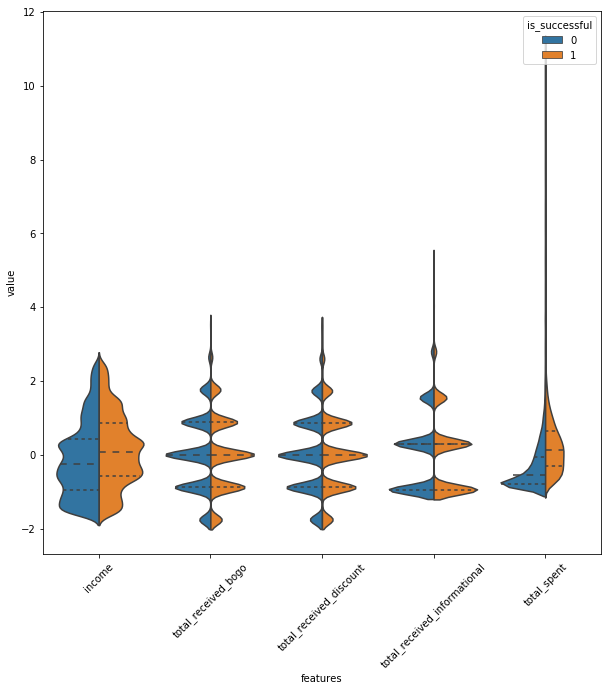

In [24]:
# Visualizing Standardized Data
## Create target dataframe
tagre_var = df_normalized.is_successful

## Create normalized numerical variables
drop_cols = ['event', 'person', 'time', 'offer_id', 'difficulty', 'duration',
       'reward', 'email', 'mobile', 'social', 'web', 'age',
       'became_member_on', 'gender', '2013', '2014', '2015', '2016',
       '2017', '2018', 'F', 'M', 'O', 'bogo', 'discount', 'difficulty_5', 'difficulty_7',
       'difficulty_10', 'difficulty_20', 'duration_5', 'duration_7',
       'duration_10']
data = df_normalized.drop(drop_cols,axis = 1 )

data_melt = pd.melt(data,id_vars="is_successful",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="is_successful", data=data_melt,split=True, inner="quart")
plt.xticks(rotation=45);

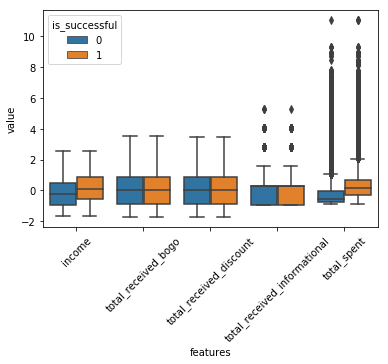

In [19]:
sns.boxplot(x='features', y='value', hue='is_successful', data=data_melt)
plt.xticks(rotation=45);

The above results indicates:

1. the mean and distriribution of `total_received_bogo`, `total_received_discount` and `total_received_informational` fr successfully and not successfully completed offer are very similiar. Therefore, using them as explanatory variables in my model will not add much to the predictin power.
2. It seems that `total_recived_bogo` and `total_received_discount` are very similar and they may be correlated. I need to dop one of them to reduce the redundency.

Let's use joint plot to compare the correlation between `total_received_bogo` and `total_received_discount`:

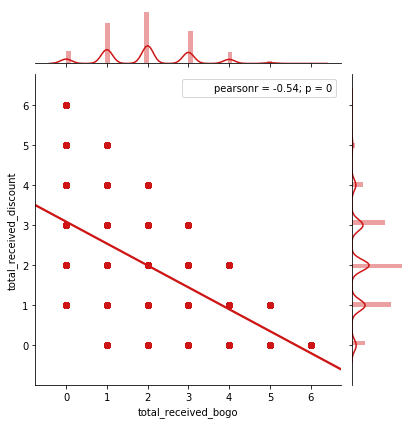

In [20]:
sns.jointplot(cleaned_df.loc[:,'total_received_bogo'],
              cleaned_df.loc[:,'total_received_discount'],
              kind="regg",
              color="#ce1414");

### Observing the Distribution of Values and their Variance with Swarm Plots

In [6]:
# plt.figure(figsize=(10,10))
# sns.swarmplot(x="features", y="value", hue="is_successful", data=data_melt)
# plt.xticks(rotation=45);

### Observing all Pair-wise Correlations

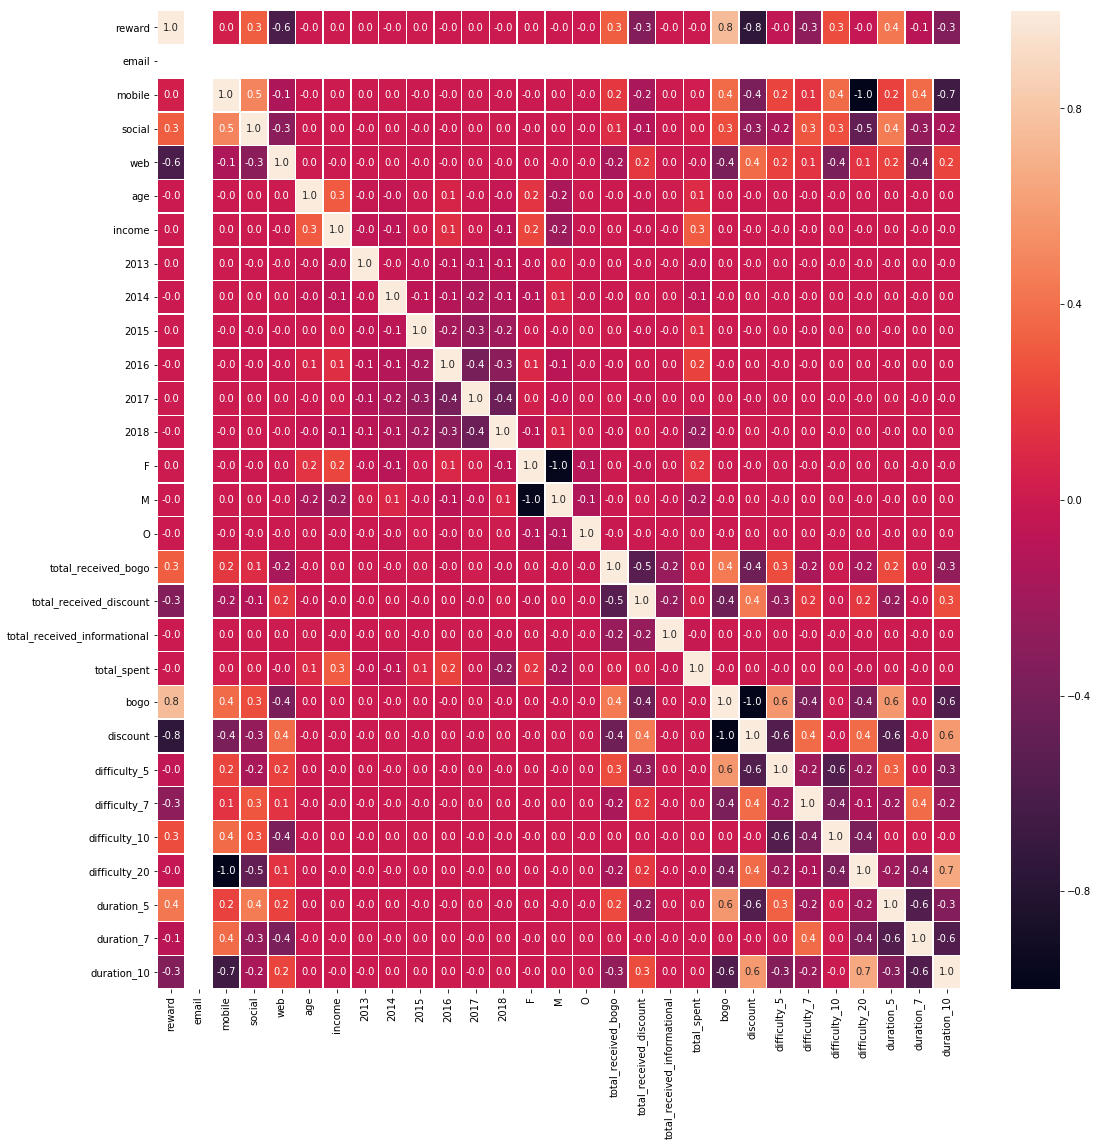

In [10]:
## Create normalized numerical variables
drop_cols = ['event', 'person', 'time', 'offer_id', 'difficulty', 'duration', 'became_member_on', 'gender', 'is_successful']
x = df_normalized.drop(drop_cols,axis = 1 )

#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

So, I do not have high correlation between my features and any redundency issue. However, there is no correlation has been estimated for `email`. This can happens if the email does not have any variation. Let's see which values `email` has got:

In [13]:
df_normalized.email.value_counts()

1.0    53201
Name: email, dtype: int64

As I suspected, email has only value 1. Therefore, I am not going to use is as explanatory feature in my modelling stage.

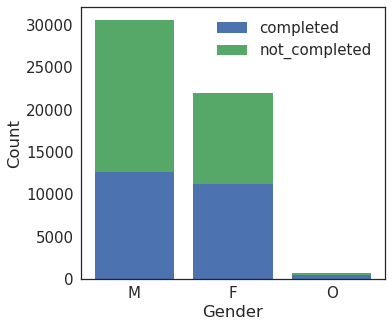

In [38]:
legend_names = ['completed', 'not_completed']

cat1_order = ['M', 'F', 'O']
cat2_order = [1, 0]

plt.figure(figsize = [12,5])

# stacked bar chart, absolute counts
plt.subplot(1, 2, 2)

baselines = np.zeros(len(cat1_order))

# for each second-variable category:
for i in range(len(cat2_order)):
    #isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df_normalized[df_normalized['is_successful'] == cat2]['gender'].value_counts()
    # then plot those counts on top of the accumulated baseline
    plt.bar(x=np.arange(len(cat1_order)), height=inner_counts[cat1_order],
           bottom=baselines)
    baselines +=inner_counts[cat1_order]
    
plt.xticks(np.arange(len(cat1_order)), cat1_order)
plt.legend(legend_names)
plt.ylabel('Count')
plt.xlabel('Gender');

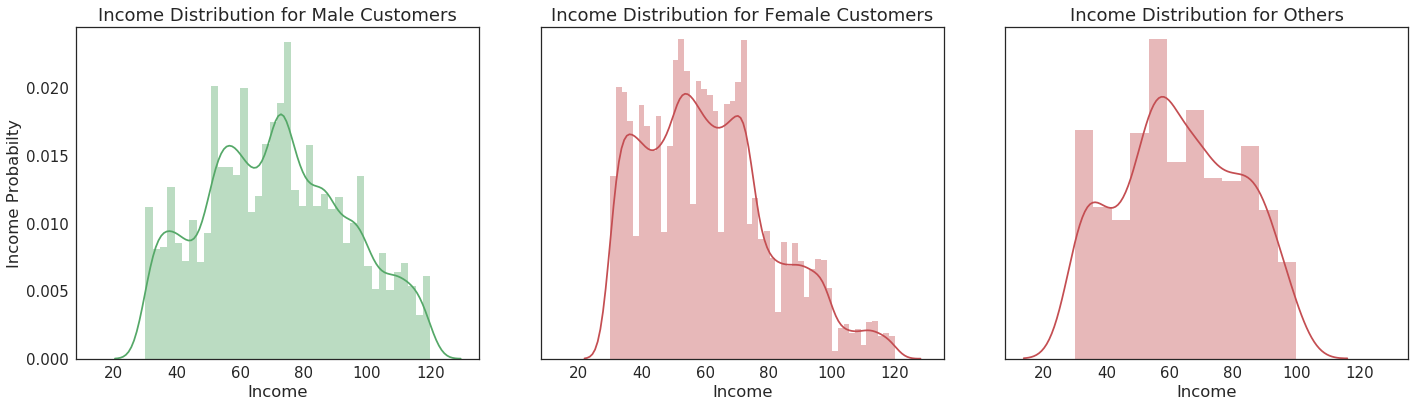

In [37]:
# Plot Income Distribution as a Function of Gender
male_customers = cleaned_df[cleaned_df['gender'] == 'F']
female_customers = cleaned_df[cleaned_df['gender'] == 'M']
other_customers = cleaned_df[cleaned_df['gender'] == 'O']

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income')
plt.ylabel('Income Probabilty')
plt.title('Income Distribution for Male Customers')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[2])
plt.xlabel('Income')
plt.title('Income Distribution for Female Customers')

plt.sca(ax[2])
sns.distplot(other_customers['income'] * 1E-3,
             color=current_palette[2])
plt.xlabel('Income')
plt.title('Income Distribution for Others')

plt.tight_layout()

In [43]:
drop_columns = ['event', 'person', 'time', 'offer_id', 'difficulty', 'duration',
       'email', 'became_member_on', 'gender', 'total_received_bogo',
       'total_received_discount', 'total_received_informational',]
ml_date = df_normalized.drop(drop_columns, axis=1)
ml_date.columns

Index(['reward', 'mobile', 'social', 'web', 'is_successful', 'age', 'income',
       '2013', '2014', '2015', '2016', '2017', '2018', 'F', 'M', 'O',
       'total_spent', 'bogo', 'discount', 'difficulty_5', 'difficulty_7',
       'difficulty_10', 'difficulty_20', 'duration_5', 'duration_7',
       'duration_10'],
      dtype='object')

In [44]:
ml_date.to_csv("ml_dataset.csv", index=False)

# 3 Modeling

---
In this section, I use two classifiers, namely random forest and logistic regression, to make th eprediction about whether an offer will be completed. Then, I will compare the result and pick the best model.

In [49]:
data = pd.read_csv("ml_dataset.csv")

In [50]:
data.sample(5)

,reward,mobile,social,web,is_successful,age,income,2013,2014,2015,2016,2017,2018,F,M,O,total_spent,bogo,discount,difficulty_5,difficulty_7,difficulty_10,difficulty_20,duration_5,duration_7,duration_10
26969,2.0,1.0,0.0,1.0,0,-0.478669,0.352529,0,0,1,0,0,0,1,0,0,-0.260116,0,1,0,0,1,0,0,1,0
43846,5.0,0.0,0.0,1.0,0,0.384149,0.121466,0,0,0,0,0,1,0,1,0,-0.572513,0,1,0,0,0,1,0,0,1
42232,5.0,1.0,0.0,1.0,0,-0.306106,-1.033851,0,0,1,0,0,0,0,1,0,-0.708271,1,0,1,0,0,0,0,1,0
48764,5.0,1.0,0.0,1.0,0,-0.536191,-0.294448,0,0,0,0,1,0,1,0,0,-0.902635,1,0,1,0,0,0,0,1,0
50915,5.0,1.0,0.0,1.0,0,-1.514052,-1.357340,0,0,0,0,1,0,0,1,0,-0.830921,1,0,1,0,0,0,0,1,0


## 3.1 Random Forest Classifier

---

In [78]:
def build_model():
    # build pipeline
    pipeline = Pipeline([

        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'clf__n_estimators': [5, 10, 20,], 
        'clf__min_samples_split': [2, 5], 
        'clf__max_features': ['auto', 'sqrt'],
        'clf__min_samples_leaf': [1, 2], 
        'clf__max_depth': [10, 20, 30], 
        'clf__bootstrap': [True, False]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv

def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)


def main():
    # perform train test split
    X = data.drop('is_successful', axis=1)
    y = data['is_successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(model, y_test, y_pred)



In [79]:
main()

Labels: [0 1]
Confusion Matrix:
 [[4494 1321]
 [1316 3510]]
Accuracy: 0.752184945024

Best Parameters: {'clf__bootstrap': False, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 20}


In [69]:
# run the random forest model with the best estimators

def main():
    # perform train test split
    X = data.drop('is_successful', axis=1)
    y = data['is_successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # build pipeline
    pipeline = Pipeline([

        ('clf', RandomForestClassifier(n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=False))
    ])
    
    # train classifier
    pipeline.fit(X_train, y_train)
    
    # predict on test data
    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test,y_pred)

    print(report)

In [70]:
main()

             precision    recall  f1-score   support

          0       0.78      0.77      0.77      5815
          1       0.72      0.73      0.73      4826

avg / total       0.75      0.75      0.75     10641



## 3.2 Logestic Regression

---

In [80]:
# perform train test split
X = data.drop(['is_successful', '2013', 'O', 'discount', 'difficulty_5', 'duration_5'], axis=1)
y = data['is_successful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# GridSearchCV
dual=[True,False]
max_iter=[100,110,120,130,140]
param_grid = dict(dual=dual,max_iter=max_iter)

lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 3, n_jobs=-1)

grid_result = grid.fit(X, y)


# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# print("Accuracy: ", grid_result.score(X,y))



Best: 0.723595 using {'dual': True, 'max_iter': 120}


In [82]:
# Best Parameters

def main():
    # perform train test split
    X = data.drop(['is_successful', '2013', 'O', 'discount', 'difficulty_5', 'duration_5'], axis=1)
    y = data['is_successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # build pipeline
    pipeline = Pipeline([

        ('lr', LogisticRegression(penalty='l2', dual=True, max_iter=120))
    ])
    
    # train classifier
    pipeline.fit(X_train, y_train)
    
    # predict on test data
    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test,y_pred)

    print(report)

In [83]:
main()

             precision    recall  f1-score   support

          0       0.73      0.79      0.76      5815
          1       0.72      0.64      0.68      4826

avg / total       0.72      0.72      0.72     10641



## 3.3 Model Comparison

the accuracy of random forest classifier is 75% whille the accuracy of the logistic regression is 72%. Therefore, baset on this metric, random forest is a better classifier for predicting wheher an offer will be completed. Using f1 metric results in the same conclusion which is using random forest classifier with f1 equals 75%.

# 4 Conclusion and future improvement

The goal of this study was to predict which offers sent by starbuck will be completed by the customer. To this end, I cleaned three dataframes and created features that could explain the success of an offer. The bets ML classifer was random forest classifier with the accuracy of 75 percentage.

It will be recomended to add which features plays the most contribution of the model success for the further improvement.